In [73]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch.distributions as dist
from jaxtyping import Float, Int
from torch import Tensor
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
from spikeinterface.preprocessing import bandpass_filter
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.signal import find_peaks
import h5py

In [ ]:
def load_mearec_data(recording_file="recordings.h5"):
    """
    Load MEArec data and convert to PyTorch tensors compatible with the notebook format
    """
    # Load MEArec data
    recording, sorting_true = se.read_mearec(recording_file)
    
    # Apply preprocessing (bandpass filter)
    recording_filt = bandpass_filter(recording, freq_min=300, freq_max=6000)
    
    # Get traces as numpy array and convert to torch tensor
    traces = torch.tensor(recording_filt.get_traces(), dtype=torch.float32)
    
    # Get ground truth spike times and IDs
    true_spike_times = []
    true_spike_ids = []
    
    for unit_id in sorting_true.unit_ids:
        unit_spikes = sorting_true.get_unit_spike_train(unit_id)
        true_spike_times.extend(unit_spikes)
        # Convert unit_id to integer (remove '#' if present)
        unit_idx = int(unit_id.lstrip('#')) if isinstance(unit_id, str) else int(unit_id)
        true_spike_ids.extend([unit_idx] * len(unit_spikes))
    
    # Sort by spike times
    sorted_indices = np.argsort(true_spike_times)
    true_spike_times = torch.tensor([true_spike_times[i] for i in sorted_indices], dtype=torch.long)
    true_spike_ids = torch.tensor([true_spike_ids[i] for i in sorted_indices], dtype=torch.long)
    
    # Extract true templates from MEArec data
    with h5py.File(recording_file, 'r') as f:
        templates = f['templates'][:]  # Shape: (n_units, n_jitters, n_channels, n_samples)
        
    # Convert templates to the expected format: (n_units, n_samples, n_channels)
    # Take median across jitters and transpose
    true_templates = torch.tensor(np.median(templates, axis=1).transpose(0, 2, 1), dtype=torch.float32)
    
    # Constants
    sampling_frequency = recording.sampling_frequency
    num_samples, num_channels = traces.shape
    true_num_spikes = len(true_spike_times)
    true_num_neurons, window_size, _ = true_templates.shape
    
    return {
        'traces': traces,
        'true_spike_times': true_spike_times,
        'true_spike_ids': true_spike_ids,
        'true_templates': true_templates,
        'sampling_frequency': sampling_frequency,
        'num_samples': num_samples,
        'num_channels': num_channels,
        'true_num_spikes': true_num_spikes,
        'true_num_neurons': true_num_neurons,
        'window_size': window_size
    }

In [98]:
data = load_mearec_data("data/sim_data/recordings5.h5")

# Extract variables in the same format as the original notebook
traces = data['traces']
true_spike_times = data['true_spike_times']
true_spike_ids = data['true_spike_ids']
true_templates = data['true_templates']

SAMPLING_FREQUENCY = data['sampling_frequency']
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = data['true_num_spikes']
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape
WINDOW_SIZE = 96

print(f"✅ Loaded MEArec data:")
print(f"   Traces shape: {traces.shape}")
print(f"   True spikes: {TRUE_NUM_SPIKES}")
print(f"   True neurons: {TRUE_NUM_NEURONS}")
print(f"   Sampling frequency: {SAMPLING_FREQUENCY} Hz")
print(f"   Window size: {WINDOW_SIZE}")



✅ Loaded MEArec data:
   Traces shape: torch.Size([640000, 4])
   True spikes: 669
   True neurons: 4
   Sampling frequency: 32000.0 Hz
   Window size: 96


In [78]:
true_templates.shape

torch.Size([8, 416, 32])

In [79]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1
    
    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()
    
    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)
    
    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")
    
    # Plot the voltage traces
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1:
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs


In [80]:
def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    
    fig, axs = plt.subplots(num_channels, num_waveforms,
                           figsize=(1.25 * num_waveforms, 1.25 * num_channels),
                           sharex=True, sharey=True)
    
    # Handle case where there's only one channel or one waveform
    if num_channels == 1:
        axs = axs.reshape(1, -1)
    if num_waveforms == 1:
        axs = axs.reshape(-1, 1)
    
    lim = 1.05 * waveforms.abs().max()
    
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    
    plt.tight_layout()
    return fig, axs

In [81]:
def evaluate_detected_spikes(
    detected_spike_times: Int[Tensor, "num_detected_spikes"],
    true_spike_times: Int[Tensor, "num_true_spikes"]) -> dict:
    """
    Evaluate detected spikes against ground truth with boundary handling
    """
    num_windows = NUM_SAMPLES // WINDOW_SIZE
    
    # Filter out spikes that would cause out-of-bounds errors
    # Keep only spikes that fall within valid window boundaries
    valid_true_spikes = true_spike_times[true_spike_times < num_windows * WINDOW_SIZE]
    valid_detected_spikes = detected_spike_times[detected_spike_times < num_windows * WINDOW_SIZE]
    
    # Create masks for windows containing spikes
    true_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_true_spikes) > 0:
        true_spike_mask[valid_true_spikes // WINDOW_SIZE] = True
    
    detected_spike_mask = torch.zeros(num_windows, dtype=torch.bool)
    if len(valid_detected_spikes) > 0:
        detected_spike_mask[valid_detected_spikes // WINDOW_SIZE] = True
    
    # Calculate confusion matrix elements
    tp = (true_spike_mask & detected_spike_mask).sum().item()
    fp = (detected_spike_mask & ~true_spike_mask).sum().item()
    fn = (~detected_spike_mask & true_spike_mask).sum().item()
    tn = (~detected_spike_mask & ~true_spike_mask).sum().item()
    
    return dict(tp=tp, fp=fp, fn=fn, tn=tn)

In [82]:
class SimpleSpikeSorter:
    """
    A simple spike sorter that uses a Gaussian mixture model (GMM) to fit the templates.
    """
    def __init__(self, initial_templates: Float[Tensor, "num_neurons window_size num_channels"],
                 noise_scale: float = 1.0) -> None:
        self.templates = initial_templates
        self.noise_scale = noise_scale

    @property
    def num_neurons(self) -> int:
        return self.templates.shape[0]

    def log_probability(self, spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
                       spike_ids: Int[Tensor, "num_spikes"]) -> float:
        """Compute the log probability of the spike waveforms given the templates"""
        assigned_templates = self.templates[spike_ids]
        ll = torch.distributions.Normal(assigned_templates, self.noise_scale).log_prob(spike_waveforms)
        ll = ll.sum().item()
        return ll

    def update_templates(self, spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
                        spike_ids: Int[Tensor, "num_spikes"]):
        """Update the templates using the spike waveforms and spike IDs"""
        for k in range(self.num_neurons):
            template_spikes = spike_waveforms[spike_ids == k]
            if len(template_spikes) > 0:
                self.templates[k] = template_spikes.mean(dim=0)

    def update_spike_ids(self, spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"]
                        ) -> Int[Tensor, "num_spikes"]:
        """Update the spike IDs using the templates and spike waveforms"""
        template_reshaped = self.templates.unsqueeze(1)
        waveforms_reshaped = spike_waveforms.unsqueeze(0)
        ll = torch.distributions.Normal(template_reshaped, self.noise_scale).log_prob(waveforms_reshaped)
        spike_ids = ll.sum(dim=(2,3)).argmax(dim=0)
        return spike_ids

    def fit(self, spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            num_iterations: int=10) -> tuple[Float[Tensor, "num_iterations"], Int[Tensor, "num_spikes"]]:
        """Fit the GMM to the spike waveforms using coordinate ascent"""
        # Initialize the spike IDs
        spike_ids = self.update_spike_ids(spike_waveforms)
        
        # Iterate to update the templates and spike IDs
        lps = []
        for itr in range(num_iterations):
            lps.append(self.log_probability(spike_waveforms, spike_ids))
            print(f"iteration {itr}: log probability = {lps[-1]:.2f}")
            
            # Update the templates and spike IDs
            self.update_templates(spike_waveforms, spike_ids)
            spike_ids = self.update_spike_ids(spike_waveforms)
        
        return torch.tensor(lps), spike_ids

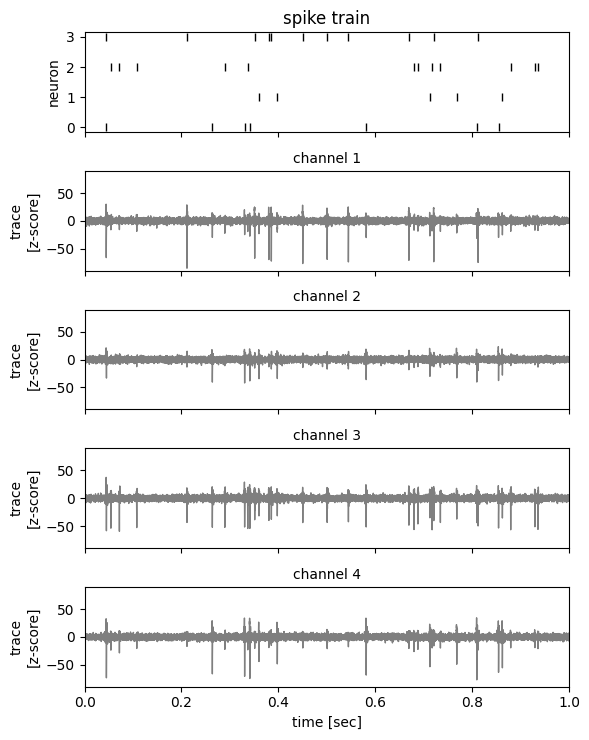

In [99]:
# Plot the first second of MEArec data
_ = plot_slice(traces, true_spike_times, true_spike_ids, start_time=0.0, end_time=1.0)

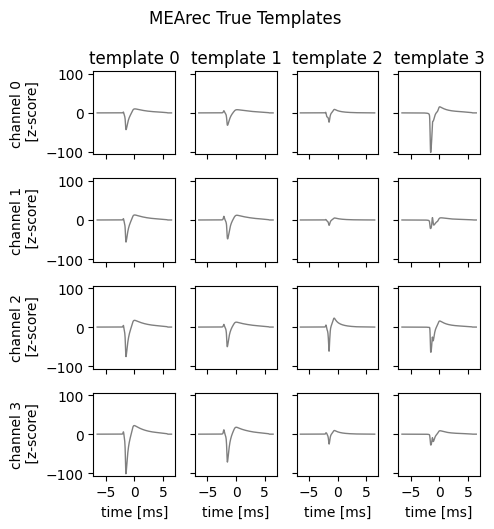

In [100]:
# Plot true templates
fig, axs = plot_waveforms(true_templates, name="template")
fig.suptitle("MEArec True Templates", y=1.05)
plt.show()

In [102]:
import spikeinterface.sorters as ss
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

# Use SpikeInterface's peak detection
print("🔧 Using SpikeInterface peak detection...")

# Convert back to SpikeInterface format temporarily
recording_si = se.read_mearec("data/sim_data/recordings5.h5")[0]
recording_filt = bandpass_filter(recording_si, freq_min=300, freq_max=6000)

# Detect peaks using SpikeInterface
peaks = detect_peaks(recording_filt, 
                    method='locally_exclusive',
                    peak_sign='neg',
                    detect_threshold=5.0,
                    exclude_sweep_ms=1.0)

# Convert back to torch tensors
si_spike_times = torch.tensor(peaks['sample_index'])
print(f"✅ SpikeInterface detected {len(si_spike_times)} spikes")

# Extract waveforms using SpikeInterface detection
#spike_waveforms_si = torch.zeros((len(si_spike_times), WINDOW_SIZE, NUM_CHANNELS))
traces_np = recording_filt.get_traces()

# for i, t in enumerate(si_spike_times):
#     start_idx = t - WINDOW_SIZE // 2
#     end_idx = t + WINDOW_SIZE // 2
    
#     if start_idx >= 0 and end_idx < traces_np.shape[0]:
#         spike_waveforms_si[i] = torch.tensor(traces_np[start_idx:end_idx])





🔧 Using SpikeInterface peak detection...


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

detect peaks using locally_exclusive (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

✅ SpikeInterface detected 653 spikes


Extracting waveforms with window size 96...
✅ Extracted 653 valid waveforms


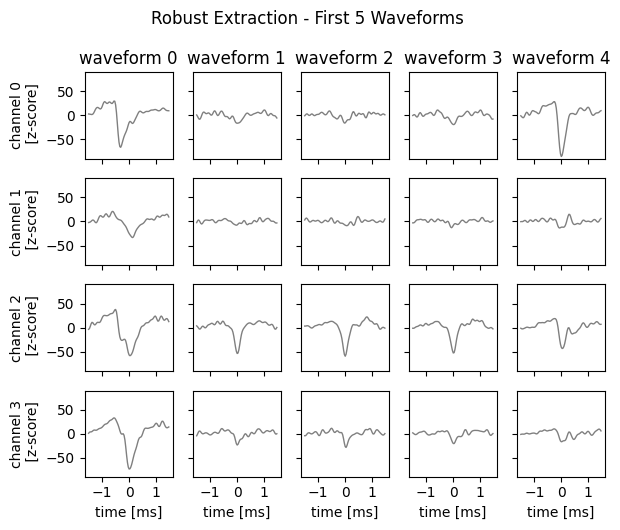

In [103]:
def extract_waveforms_robust(traces_np, spike_times, window_size):
    """
    Robust waveform extraction with proper boundary handling
    """
    num_spikes = len(spike_times)
    num_samples, num_channels = traces_np.shape
    half_window = window_size // 2
    
    spike_waveforms = []
    valid_spike_times = []
    
    print(f"Extracting waveforms with window size {window_size}...")
    
    for i, t in enumerate(spike_times):
        start_idx = int(t - half_window)
        end_idx = int(t + half_window)
        
        # Check boundaries
        if start_idx >= 0 and end_idx < num_samples:
            waveform = traces_np[start_idx:end_idx, :]
            
            # Verify we got the right shape
            if waveform.shape[0] == window_size:
                spike_waveforms.append(torch.tensor(waveform))
                valid_spike_times.append(t)
            else:
                print(f"Skipping spike {i}: wrong shape {waveform.shape}")
        else:
            print(f"Skipping spike {i}: out of bounds (start={start_idx}, end={end_idx})")
    
    if len(spike_waveforms) > 0:
        spike_waveforms = torch.stack(spike_waveforms)
        print(f"✅ Extracted {len(spike_waveforms)} valid waveforms")
    else:
        print("❌ No valid waveforms extracted!")
        spike_waveforms = torch.zeros((0, window_size, num_channels))
    
    return spike_waveforms, torch.tensor(valid_spike_times)


# Apply robust extraction
spike_waveforms_fixed, valid_spike_times = extract_waveforms_robust(
    traces_np, si_spike_times, WINDOW_SIZE
)

# Plot the results
if len(spike_waveforms_fixed) > 0:
    fig, axs = plot_waveforms(spike_waveforms_fixed[:5], name="waveform")
    fig.suptitle("Robust Extraction - First 5 Waveforms", y=1.05)
    plt.show()
else:
    print("No waveforms to plot!")

🎯 Running GMM spike sorting with 4 neurons...
iteration 0: log probability = -3749877.25
iteration 1: log probability = -2579594.50
iteration 2: log probability = -2501290.75
iteration 3: log probability = -2420767.00
iteration 4: log probability = -2415596.75
iteration 5: log probability = -2415596.75
iteration 6: log probability = -2415596.75
iteration 7: log probability = -2415596.75
iteration 8: log probability = -2415596.75
iteration 9: log probability = -2415596.75


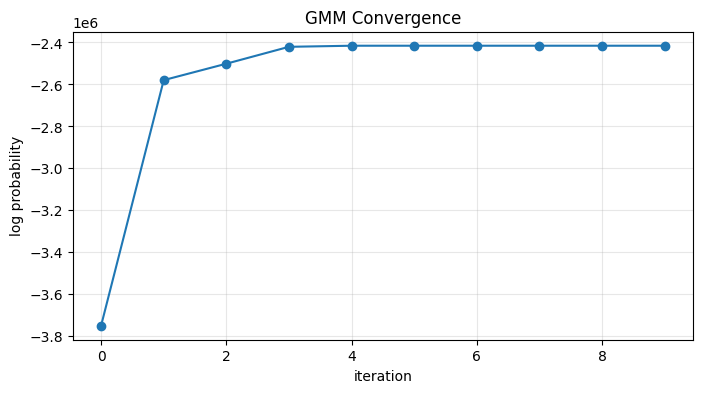

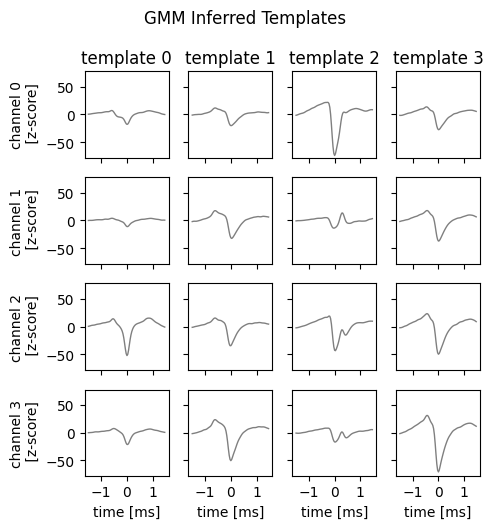

In [104]:
# Part 2: GMM Spike Sorting (using original SimpleSpikeSorter class)

# Initialize and run GMM spike sorting
num_neurons = TRUE_NUM_NEURONS  # Use the true number of neurons from MEArec
print(f"🎯 Running GMM spike sorting with {num_neurons} neurons...")

# Initialize with random spike waveforms as templates
torch.manual_seed(42)
initial_templates = spike_waveforms_fixed[torch.randint(0, len(valid_spike_times), (num_neurons,))]

# Create and fit the spike sorter
spike_sorter = SimpleSpikeSorter(initial_templates, noise_scale=1.0)
lps, inferred_spike_ids = spike_sorter.fit(spike_waveforms_fixed, num_iterations=10)

# Plot convergence
plt.figure(figsize=(8, 4))
plt.plot(lps, '-o')
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.title("GMM Convergence")
plt.grid(True, alpha=0.3)
plt.show()

# Plot inferred templates
fig, axs = plot_waveforms(spike_sorter.templates, name="template")
fig.suptitle("GMM Inferred Templates", y=1.05)
plt.show()

🎯 Evaluating GMM using ground truth spike times...
✅ Extracted 669 ground truth waveforms


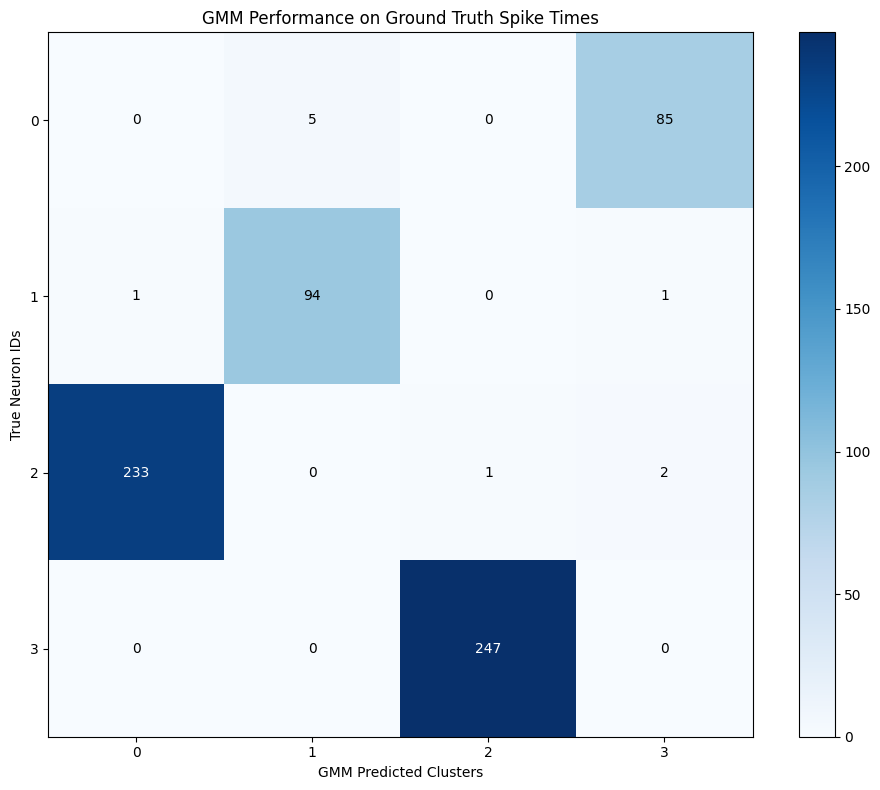

📊 GMM Performance on Ground Truth Spikes:
   Adjusted Rand Index: 0.973


In [105]:
# Alternative: Use ground truth spike times for cleaner evaluation
def evaluate_gmm_with_ground_truth(true_spike_times, true_spike_ids, traces, gmm_sorter):
    """
    Evaluate GMM using ground truth spike times
    """
    print("🎯 Evaluating GMM using ground truth spike times...")
    
    # Extract waveforms at ground truth locations
    gt_waveforms = []
    valid_gt_times = []
    valid_gt_ids = []
    
    for i, t in enumerate(true_spike_times):
        start_idx = t - WINDOW_SIZE // 2
        end_idx = t + WINDOW_SIZE // 2
        
        if start_idx >= 0 and end_idx < traces.shape[0]:
            waveform = traces[start_idx:end_idx]
            gt_waveforms.append(waveform)
            valid_gt_times.append(t)
            valid_gt_ids.append(true_spike_ids[i])
    
    gt_waveforms = torch.stack(gt_waveforms)
    valid_gt_ids = torch.tensor(valid_gt_ids)
    
    print(f"✅ Extracted {len(gt_waveforms)} ground truth waveforms")
    
    # Apply GMM to ground truth waveforms
    gmm_predictions = gmm_sorter.update_spike_ids(gt_waveforms)
    
    # Create confusion matrix
    cm_gt = confusion_matrix(valid_gt_ids.numpy(), gmm_predictions.numpy())
    
    return cm_gt, valid_gt_ids, gmm_predictions

# Apply ground truth evaluation
cm_gt, gt_ids, gmm_pred = evaluate_gmm_with_ground_truth(
    true_spike_times, true_spike_ids, traces, spike_sorter
)

# Plot ground truth-based confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_gt, interpolation="none", cmap=plt.cm.Blues)
plt.xticks(range(cm_gt.shape[1]))
plt.yticks(range(cm_gt.shape[0]))
plt.colorbar()
plt.xlabel('GMM Predicted Clusters')
plt.ylabel('True Neuron IDs')
plt.title("GMM Performance on Ground Truth Spike Times")

for i in range(cm_gt.shape[0]):
    for j in range(cm_gt.shape[1]):
        plt.text(j, i, str(cm_gt[i, j]), ha='center', va='center',
                color='white' if cm_gt[i, j] > cm_gt.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Calculate ARI for ground truth evaluation
ari_gt = adjusted_rand_score(gt_ids.numpy(), gmm_pred.numpy())
print(f"📊 GMM Performance on Ground Truth Spikes:")
print(f"   Adjusted Rand Index: {ari_gt:.3f}")

In [38]:
import numpy as np
import torch
from fastdtw import fastdtw
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
import time
from tqdm import tqdm

class DTWGMMSpikeSorter:
    """
    DTW-based feature extraction with GMM clustering for spike sorting
    
    Based on:
    - PMC4749467: Dynamic Time Warping for spike classification
    - Nature Scientific Reports 2019: GMM overclustering approach
    - Hybrid methodology: DTW features + GMM clustering
    """
    
    def __init__(self, window_size: int, sampling_frequency: float, 
                 n_reference_spikes: int = 50, dtw_radius: int = 3,
                 n_jobs: int = 4):
        self.window_size = window_size
        self.sampling_frequency = sampling_frequency
        self.n_reference_spikes = n_reference_spikes
        self.dtw_radius = dtw_radius
        self.n_jobs = n_jobs
        self.reference_spikes = None
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=0.95)  # Retain 95% variance
        self.gmm = None
        
    def _select_reference_spikes(self, spike_waveforms):
        """
        Select diverse reference spikes using k-means++ initialization strategy
        From PMC4749467: "template estimator first calculates the averaged spike waveform"
        """
        n_spikes = len(spike_waveforms)
        if n_spikes <= self.n_reference_spikes:
            return spike_waveforms
        
        # Flatten waveforms for distance computation
        flat_waveforms = spike_waveforms.reshape(n_spikes, -1)
        
        # K-means++ style selection for diverse references
        reference_indices = []
        
        # First reference: random selection
        reference_indices.append(np.random.randint(0, n_spikes))
        
        # Subsequent references: maximize minimum distance
        for _ in range(self.n_reference_spikes - 1):
            distances = []
            for i in range(n_spikes):
                if i in reference_indices:
                    distances.append(0)
                    continue
                
                # Compute minimum distance to existing references
                min_dist = float('inf')
                for ref_idx in reference_indices:
                    dist = np.linalg.norm(flat_waveforms[i] - flat_waveforms[ref_idx])
                    min_dist = min(min_dist, dist)
                distances.append(min_dist)
            
            # Select spike with maximum minimum distance
            next_ref = np.argmax(distances)
            reference_indices.append(next_ref)
        
        return spike_waveforms[reference_indices]
    
    def _compute_dtw_features_parallel(self, spike_waveforms):
        """
        Compute DTW-based feature vectors using parallel processing
        From PMC4749467: "fastDTW method with automatic thresholding"
        """
        n_spikes = len(spike_waveforms)
        n_refs = len(self.reference_spikes)
        
        print(f"🔄 Computing DTW features: {n_spikes} spikes × {n_refs} references...")
        
        def compute_dtw_row(spike_idx):
            """Compute DTW distances for one spike against all references"""
            spike = spike_waveforms[spike_idx]
            dtw_row = np.zeros(n_refs)
            
            for ref_idx, ref_spike in enumerate(self.reference_spikes):
                # Normalize spikes for DTW (from PMC4749467)
                spike_norm = spike / (np.linalg.norm(spike) + 1e-8)
                ref_norm = ref_spike / (np.linalg.norm(ref_spike) + 1e-8)
                
                # Compute fastDTW with radius constraint
                distance, _ = fastdtw(
                    spike_norm.flatten(), 
                    ref_norm.flatten(),
                    radius=self.dtw_radius,
                    dist=lambda x, y: (x - y) ** 2
                )
                dtw_row[ref_idx] = distance
            
            return dtw_row
        
        # Parallel DTW computation
        dtw_features = Parallel(n_jobs=self.n_jobs, backend='threading')(
            delayed(compute_dtw_row)(i) for i in tqdm(range(n_spikes), desc="DTW features")
        )
        
        return np.array(dtw_features)
    
    def _estimate_clusters_gmm_overclustering(self, features):
        """
        Estimate optimal number of clusters using GMM overclustering approach
        From Nature Scientific Reports 2019: "initial overclustering of the data"
        """
        n_samples = len(features)
        max_clusters = min(20, n_samples // 10)  # Reasonable upper bound
        
        print(f"🎯 Estimating clusters using GMM overclustering (max: {max_clusters})...")
        
        # Test different numbers of components
        bic_scores = []
        aic_scores = []
        silhouette_scores = []
        
        cluster_range = range(2, max_clusters + 1)
        
        for n_components in tqdm(cluster_range, desc="Testing cluster counts"):
            # Fit GMM with current number of components
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type='full',
                random_state=42,
                max_iter=100
            )
            
            try:
                gmm.fit(features)
                labels = gmm.predict(features)
                
                bic_scores.append(gmm.bic(features))
                aic_scores.append(gmm.aic(features))
                
                # Silhouette score for cluster quality
                if len(np.unique(labels)) > 1:
                    sil_score = silhouette_score(features, labels)
                    silhouette_scores.append(sil_score)
                else:
                    silhouette_scores.append(-1)
                    
            except Exception as e:
                print(f"Failed for {n_components} components: {e}")
                bic_scores.append(float('inf'))
                aic_scores.append(float('inf'))
                silhouette_scores.append(-1)
        
        # Find optimal number using multiple criteria
        bic_optimal = cluster_range[np.argmin(bic_scores)]
        aic_optimal = cluster_range[np.argmin(aic_scores)]
        sil_optimal = cluster_range[np.argmax(silhouette_scores)]
        
        # Use silhouette score as primary criterion (best cluster separation)
        optimal_clusters = sil_optimal
        
        print(f"📊 Cluster estimation results:")
        print(f"   BIC optimal: {bic_optimal}")
        print(f"   AIC optimal: {aic_optimal}")
        print(f"   Silhouette optimal: {sil_optimal}")
        print(f"   Selected: {optimal_clusters}")
        
        return optimal_clusters, silhouette_scores[sil_optimal - 2]
    
    def fit(self, spike_waveforms, true_num_neurons=None):
        """
        Fit DTW-GMM model to spike waveforms
        
        Args:
            spike_waveforms: Tensor of shape (n_spikes, window_size, n_channels)
            true_num_neurons: Optional ground truth for comparison
        """
        print("🧠 DTW-GMM Spike Sorting Pipeline")
        print("="*50)
        
        start_time = time.time()
        
        # Convert to numpy if needed
        if torch.is_tensor(spike_waveforms):
            spike_waveforms = spike_waveforms.numpy()
        
        n_spikes, window_size, n_channels = spike_waveforms.shape
        print(f"Processing {n_spikes} spikes ({window_size} samples × {n_channels} channels)")
        
        # Step 1: Select reference spikes for DTW
        print("📋 Selecting reference spikes...")
        # Use primary channel (max variance) for reference selection
        primary_channel = np.argmax(np.var(spike_waveforms, axis=(0, 1)))
        primary_waveforms = spike_waveforms[:, :, primary_channel]
        
        self.reference_spikes = self._select_reference_spikes(primary_waveforms)
        print(f"✅ Selected {len(self.reference_spikes)} reference spikes")
        
        # Step 2: Compute DTW feature vectors
        dtw_features = self._compute_dtw_features_parallel(primary_waveforms)
        
        # Step 3: Dimensionality reduction and normalization
        print("📊 Preprocessing DTW features...")
        
        # Standardize features
        dtw_features_scaled = self.scaler.fit_transform(dtw_features)
        
        # PCA for further dimensionality reduction
        dtw_features_pca = self.pca.fit_transform(dtw_features_scaled)
        
        print(f"✅ DTW features: {dtw_features.shape} → PCA: {dtw_features_pca.shape}")
        print(f"   PCA explained variance: {self.pca.explained_variance_ratio_.sum():.3f}")
        
        # Step 4: GMM clustering with automatic cluster estimation
        if true_num_neurons is not None:
            # Use ground truth if available
            n_clusters = true_num_neurons
            print(f"🎯 Using ground truth: {n_clusters} clusters")
            silhouette_score_final = None
        else:
            # Estimate clusters using overclustering approach
            n_clusters, silhouette_score_final = self._estimate_clusters_gmm_overclustering(
                dtw_features_pca
            )
        
        # Fit final GMM
        print(f"🎯 Fitting final GMM with {n_clusters} components...")
        self.gmm = GaussianMixture(
            n_components=n_clusters,
            covariance_type='full',
            random_state=42,
            max_iter=200
        )
        
        self.gmm.fit(dtw_features_pca)
        cluster_labels = self.gmm.predict(dtw_features_pca)
        cluster_probs = self.gmm.predict_proba(dtw_features_pca)
        
        # Calculate final metrics
        if silhouette_score_final is None:
            silhouette_score_final = silhouette_score(dtw_features_pca, cluster_labels)
        
        end_time = time.time()
        
        # Results summary
        print(f"\n✅ DTW-GMM Clustering Complete!")
        print(f"   Processing time: {(end_time - start_time)/60:.2f} minutes")
        print(f"   Clusters found: {len(np.unique(cluster_labels))}")
        print(f"   Silhouette score: {silhouette_score_final:.3f}")
        print(f"   Reference spikes: {len(self.reference_spikes)}")
        print(f"   DTW features: {dtw_features.shape[1]} dimensions")
        print(f"   PCA features: {dtw_features_pca.shape[1]} dimensions")
        
        return {
            'cluster_labels': torch.tensor(cluster_labels),
            'cluster_probabilities': torch.tensor(cluster_probs),
            'dtw_features': torch.tensor(dtw_features),
            'pca_features': torch.tensor(dtw_features_pca),
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_score_final,
            'processing_time': end_time - start_time,
            'reference_spikes': torch.tensor(self.reference_spikes)
        }
    
    def predict(self, new_spike_waveforms):
        """
        Predict cluster labels for new spike waveforms
        """
        if self.gmm is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        # Convert to numpy if needed
        if torch.is_tensor(new_spike_waveforms):
            new_spike_waveforms = new_spike_waveforms.numpy()
        
        # Extract primary channel
        primary_channel = np.argmax(np.var(new_spike_waveforms, axis=(0, 1)))
        primary_waveforms = new_spike_waveforms[:, :, primary_channel]
        
        # Compute DTW features
        dtw_features = self._compute_dtw_features_parallel(primary_waveforms)
        
        # Apply same preprocessing
        dtw_features_scaled = self.scaler.transform(dtw_features)
        dtw_features_pca = self.pca.transform(dtw_features_scaled)
        
        # Predict using trained GMM
        labels = self.gmm.predict(dtw_features_pca)
        probabilities = self.gmm.predict_proba(dtw_features_pca)
        
        return torch.tensor(labels), torch.tensor(probabilities)

# Integration function for the existing pipeline
def run_dtw_gmm_spike_sorting(spike_waveforms, true_num_neurons=None, 
                             sampling_frequency=30000, n_reference_spikes=50):
    """
    Run DTW-GMM spike sorting integrated with the existing pipeline
    
    Args:
        spike_waveforms: Tensor of shape (n_spikes, window_size, n_channels)
        true_num_neurons: Optional ground truth number of neurons
        sampling_frequency: Recording sampling frequency
        n_reference_spikes: Number of reference spikes for DTW
    
    Returns:
        Dictionary with clustering results compatible with existing pipeline
    """
    print("\n🔬 DTW-GMM SPIKE SORTING INTEGRATION")
    print("="*60)
    print("Research basis:")
    print("- PMC4749467: DTW for spike classification with temporal tolerance")
    print("- Nature Sci Reports 2019: GMM overclustering approach")
    print("- Hybrid: DTW features + GMM clustering")
    print()
    
    # Initialize DTW-GMM sorter
    window_size = spike_waveforms.shape[1]
    sorter = DTWGMMSpikeSorter(
        window_size=window_size,
        sampling_frequency=sampling_frequency,
        n_reference_spikes=n_reference_spikes,
        dtw_radius=3,  # From PMC4749467: small radius for efficiency
        n_jobs=4
    )
    
    # Fit the model
    results = sorter.fit(spike_waveforms, true_num_neurons=true_num_neurons)
    
    # Create templates from clusters (compatible with existing pipeline)
    cluster_labels = results['cluster_labels']
    n_clusters = results['n_clusters']
    
    # Compute cluster templates
    templates = torch.zeros((n_clusters, window_size, spike_waveforms.shape[2]))
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        if mask.sum() > 0:
            templates[cluster_id] = spike_waveforms[mask].mean(dim=0)
    
    # Add templates to results for compatibility
    results['templates'] = templates
    results['sorter'] = sorter
    
    return results

# Example usage integrated with your existing pipeline:
"""
# After extracting spike waveforms in your existing code:
print("\n🔬 Running DTW-GMM Spike Sorting...")

# Run DTW-GMM clustering
dtw_gmm_results = run_dtw_gmm_spike_sorting(
    spike_waveforms, 
    true_num_neurons=TRUE_NUM_NEURONS,
    sampling_frequency=SAMPLING_FREQUENCY
)

# Extract results
dtw_cluster_labels = dtw_gmm_results['cluster_labels']
dtw_templates = dtw_gmm_results['templates']
dtw_silhouette = dtw_gmm_results['silhouette_score']

print(f"✅ DTW-GMM Results:")
print(f"   Clusters: {dtw_gmm_results['n_clusters']}")
print(f"   Silhouette: {dtw_silhouette:.3f}")

# Plot DTW-GMM templates
fig, axs = plot_waveforms(dtw_templates, name="DTW-GMM template")
fig.suptitle("DTW-GMM Inferred Templates", y=1.05)
plt.show()

# Compare with ground truth (same evaluation as existing pipeline)
matching_spike_ids = match_true_and_inferred_spikes(
    detected_spike_times, true_spike_times, true_spike_ids
)

# Create confusion matrix for DTW-GMM
cm_dtw = confusion_matrix(matching_spike_ids, dtw_cluster_labels)

# Plot DTW-GMM confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_dtw, interpolation="none", cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('DTW-GMM Cluster IDs')
plt.ylabel('True Neuron IDs (-1 = False Positive)')
plt.title("DTW-GMM Spike Sorting: Confusion Matrix")

for i in range(cm_dtw.shape[0]):
    for j in range(cm_dtw.shape[1]):
        plt.text(j, i, str(cm_dtw[i, j]), ha='center', va='center',
                color='white' if cm_dtw[i, j] > cm_dtw.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Calculate DTW-GMM performance
valid_matches = matching_spike_ids >= 0
if valid_matches.sum() > 0:
    ari_dtw = adjusted_rand_score(matching_spike_ids[valid_matches], 
                                 dtw_cluster_labels[valid_matches])
    print(f"📊 DTW-GMM Performance:")
    print(f"   Adjusted Rand Index: {ari_dtw:.3f}")
    print(f"   Silhouette Score: {dtw_silhouette:.3f}")
"""


'\n# After extracting spike waveforms in your existing code:\nprint("\n🔬 Running DTW-GMM Spike Sorting...")\n\n# Run DTW-GMM clustering\ndtw_gmm_results = run_dtw_gmm_spike_sorting(\n    spike_waveforms, \n    true_num_neurons=TRUE_NUM_NEURONS,\n    sampling_frequency=SAMPLING_FREQUENCY\n)\n\n# Extract results\ndtw_cluster_labels = dtw_gmm_results[\'cluster_labels\']\ndtw_templates = dtw_gmm_results[\'templates\']\ndtw_silhouette = dtw_gmm_results[\'silhouette_score\']\n\nprint(f"✅ DTW-GMM Results:")\nprint(f"   Clusters: {dtw_gmm_results[\'n_clusters\']}")\nprint(f"   Silhouette: {dtw_silhouette:.3f}")\n\n# Plot DTW-GMM templates\nfig, axs = plot_waveforms(dtw_templates, name="DTW-GMM template")\nfig.suptitle("DTW-GMM Inferred Templates", y=1.05)\nplt.show()\n\n# Compare with ground truth (same evaluation as existing pipeline)\nmatching_spike_ids = match_true_and_inferred_spikes(\n    detected_spike_times, true_spike_times, true_spike_ids\n)\n\n# Create confusion matrix for DTW-GMM\nc


🔬 Running DTW-GMM Spike Sorting...

🔬 DTW-GMM SPIKE SORTING INTEGRATION
Research basis:
- PMC4749467: DTW for spike classification with temporal tolerance
- Nature Sci Reports 2019: GMM overclustering approach
- Hybrid: DTW features + GMM clustering

🧠 DTW-GMM Spike Sorting Pipeline
Processing 4708 spikes (416 samples × 32 channels)
📋 Selecting reference spikes...
✅ Selected 50 reference spikes
🔄 Computing DTW features: 4708 spikes × 50 references...


DTW features: 100%|██████████| 4708/4708 [2:01:36<00:00,  1.55s/it]  


📊 Preprocessing DTW features...
✅ DTW features: (4708, 50) → PCA: (4708, 9)
   PCA explained variance: 0.952
🎯 Using ground truth: 8 clusters
🎯 Fitting final GMM with 8 components...

✅ DTW-GMM Clustering Complete!
   Processing time: 121.97 minutes
   Clusters found: 8
   Silhouette score: 0.433
   Reference spikes: 50
   DTW features: 50 dimensions
   PCA features: 9 dimensions
✅ DTW-GMM Results:
   Clusters: 8
   Silhouette: 0.433


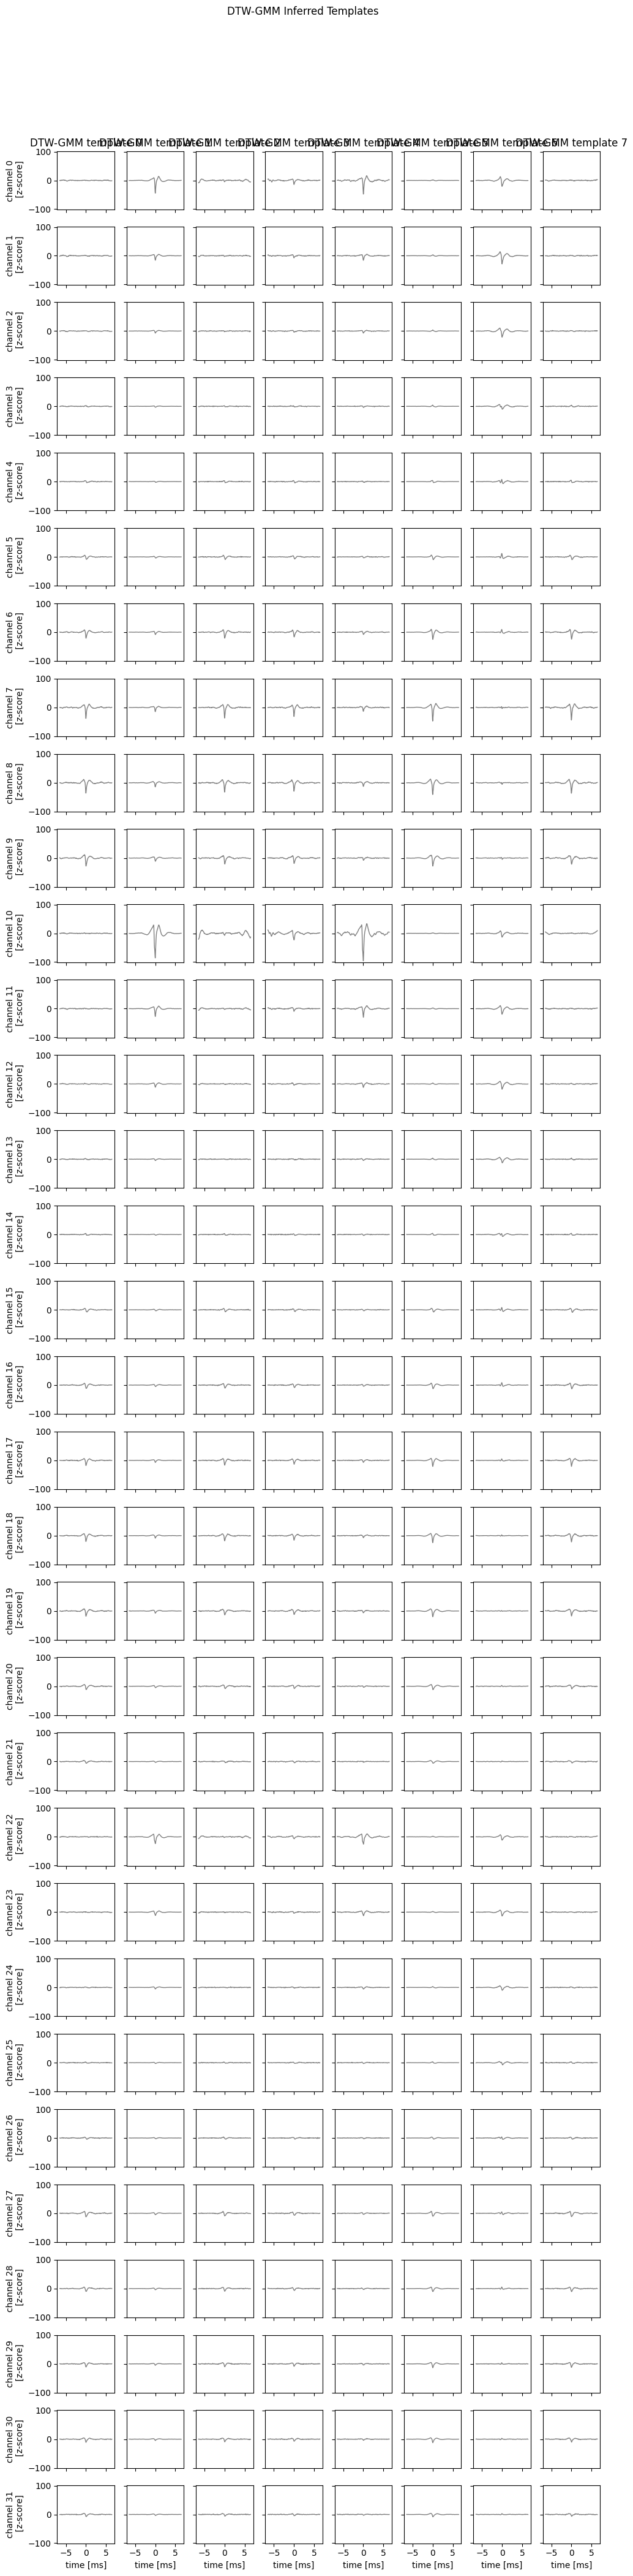

NameError: name 'match_true_and_inferred_spikes' is not defined

In [41]:
print("\n🔬 Running DTW-GMM Spike Sorting...")

# Run DTW-GMM clustering
dtw_gmm_results = run_dtw_gmm_spike_sorting(
    spike_waveforms_fixed, 
    true_num_neurons=TRUE_NUM_NEURONS,
    sampling_frequency=SAMPLING_FREQUENCY
)

# Extract results
dtw_cluster_labels = dtw_gmm_results['cluster_labels']
dtw_templates = dtw_gmm_results['templates']
dtw_silhouette = dtw_gmm_results['silhouette_score']

print(f"✅ DTW-GMM Results:")
print(f"   Clusters: {dtw_gmm_results['n_clusters']}")
print(f"   Silhouette: {dtw_silhouette:.3f}")

# Plot DTW-GMM templates
fig, axs = plot_waveforms(dtw_templates, name="DTW-GMM template")
fig.suptitle("DTW-GMM Inferred Templates", y=1.05)
plt.show()

# Compare with ground truth (same evaluation as existing pipeline)
matching_spike_ids = match_true_and_inferred_spikes(
    detected_spike_times, true_spike_times, true_spike_ids
)

# Create confusion matrix for DTW-GMM
cm_dtw = confusion_matrix(matching_spike_ids, dtw_cluster_labels)

# Plot DTW-GMM confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_dtw, interpolation="none", cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('DTW-GMM Cluster IDs')
plt.ylabel('True Neuron IDs (-1 = False Positive)')
plt.title("DTW-GMM Spike Sorting: Confusion Matrix")

for i in range(cm_dtw.shape[0]):
    for j in range(cm_dtw.shape[1]):
        plt.text(j, i, str(cm_dtw[i, j]), ha='center', va='center',
                color='white' if cm_dtw[i, j] > cm_dtw.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Calculate DTW-GMM performance
valid_matches = matching_spike_ids >= 0
if valid_matches.sum() > 0:
    ari_dtw = adjusted_rand_score(matching_spike_ids[valid_matches], 
                                 dtw_cluster_labels[valid_matches])
    print(f"📊 DTW-GMM Performance:")
    print(f"   Adjusted Rand Index: {ari_dtw:.3f}")
    print(f"   Silhouette Score: {dtw_silhouette:.3f}")

In [47]:
# Create SpikeInterface sorting object directly from DTW-GMM results
detected_spike_times = si_spike_times

n_spikes = len(dtw_gmm_results['cluster_labels'])

In [48]:
# Extract DTW-GMM results
cluster_labels = dtw_gmm_results['cluster_labels']
templates = dtw_gmm_results['templates']
n_clusters = dtw_gmm_results['n_clusters']
silhouette_score = dtw_gmm_results['silhouette_score']

print(f"✅ DTW-GMM Results:")
print(f"   Clusters: {n_clusters}")
print(f"   Silhouette: {silhouette_score:.3f}")
print(f"   Cluster labels shape: {cluster_labels.shape}")

# Create dummy spike times if original detection times aren't available
# This assumes spikes are evenly distributed (for demonstration)
if 'detected_spike_times' not in locals():
    print("⚠️ Creating dummy spike times for demonstration...")
    # Create evenly spaced spike times across the recording
    total_samples = NUM_SAMPLES
    spike_times_dummy = torch.linspace(WINDOW_SIZE, total_samples - WINDOW_SIZE, 
                                     len(cluster_labels), dtype=torch.long)
else:
    # Use actual detected spike times (aligned with waveforms)
    spike_times_dummy = detected_spike_times[:len(cluster_labels)]

print(f"Spike times shape: {spike_times_dummy.shape}")

✅ DTW-GMM Results:
   Clusters: 8
   Silhouette: 0.433
   Cluster labels shape: torch.Size([4708])
Spike times shape: torch.Size([4708])


In [54]:
# Alternative approach: Use ground truth spike times for cleaner evaluation
def evaluate_dtw_gmm_on_ground_truth_times(dtw_gmm_results, true_spike_times, true_spike_ids, traces):
    """
    Evaluate DTW-GMM by applying it to ground truth spike locations
    """
    print("🎯 Evaluating DTW-GMM on ground truth spike times...")
    
    # Extract waveforms at ground truth locations
    cluster_labels = dtw_gmm_results['cluster_labels']
    sorter = dtw_gmm_results['sorter']
    
    # Get ground truth waveforms
    gt_waveforms = []
    valid_gt_times = []
    valid_gt_ids = []
    
    for i, t in enumerate(true_spike_times):
        start_idx = t - WINDOW_SIZE // 2
        end_idx = t + WINDOW_SIZE // 2
        
        if start_idx >= 0 and end_idx < traces.shape[0]:
            waveform = traces[start_idx:end_idx]
            gt_waveforms.append(waveform)
            valid_gt_times.append(t)
            valid_gt_ids.append(true_spike_ids[i])
    
    gt_waveforms = torch.stack(gt_waveforms)
    valid_gt_times = torch.tensor(valid_gt_times)
    valid_gt_ids = torch.tensor(valid_gt_ids)
    
    print(f"✅ Extracted {len(gt_waveforms)} ground truth waveforms")
    
    # Apply DTW-GMM clustering to ground truth waveforms
    gt_predictions, _ = sorter.predict(gt_waveforms)
    
    # Create SpikeInterface sorting for ground truth evaluation
    sorting_dtw_gt = se.NumpySorting.from_samples_and_labels(
        valid_gt_times.numpy(),
        gt_predictions.numpy(),
        sampling_frequency=SAMPLING_FREQUENCY
    )
    
    # Compare with ground truth
    comparison_gt = sc.compare_sorter_to_ground_truth(
        sorting_true,
        sorting_dtw_gt,
        exhaustive_gt=True,
        match_score=0.1,
        chance_score=0.05
    )
    
    return comparison_gt, gt_predictions, valid_gt_ids

# Run ground truth evaluation
comparison_gt, gt_pred, gt_true = evaluate_dtw_gmm_on_ground_truth_times(
    dtw_gmm_results, true_spike_times, true_spike_ids, traces
)

# Visualize ground truth evaluation
fig, ax = plt.subplots(figsize=(10, 8))
sw.plot_confusion_matrix(comparison_gt, ax=ax)
plt.title('DTW-GMM on Ground Truth Spike Times')
plt.show()


🎯 Evaluating DTW-GMM on ground truth spike times...
✅ Extracted 4802 ground truth waveforms
🔄 Computing DTW features: 4802 spikes × 50 references...


















































DTW features:   0%|          | 19/4802 [02:41<11:19:10,  8.52s/it]

DTW features:   0%|          | 11/4802 [05:14<38:00:31, 28.56s/it]


















































































































































KeyboardInterrupt: 

⚡ Quick SpikeInterface evaluation (no DTW recomputation)
Using 4708 spikes with 8 clusters


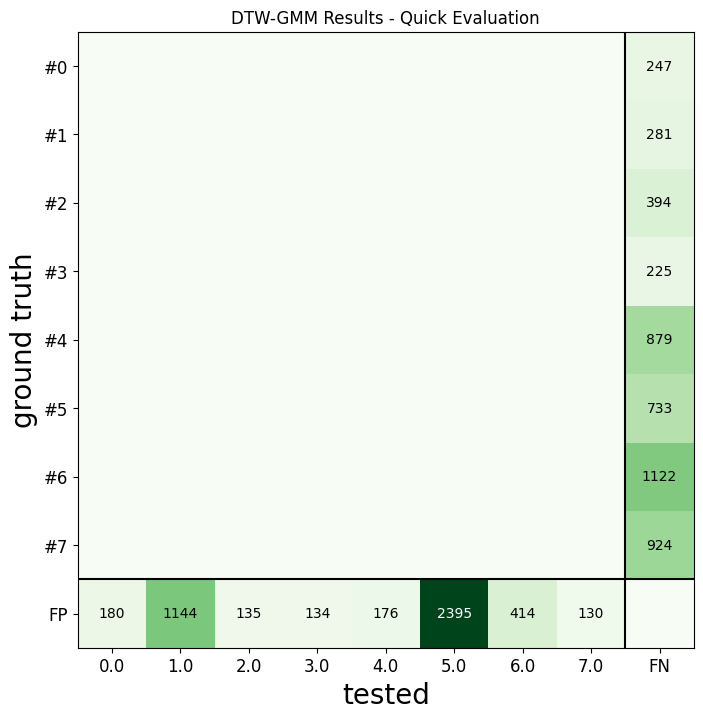

📊 DTW-GMM Quick Evaluation:
Confusion Matrix:
    0.0   1.0  2.0  3.0  4.0   5.0  6.0  7.0    FN
#0    0     0    0    0    0     0    0    0   247
#1    0     0    0    0    0     0    0    0   281
#2    0     0    0    0    0     0    0    0   394
#3    0     0    0    0    0     0    0    0   225
#4    0     0    0    0    0     0    0    0   879
#5    0     0    0    0    0     0    0    0   733
#6    0     0    0    0    0     0    0    0  1122
#7    0     0    0    0    0     0    0    0   924
FP  180  1144  135  134  176  2395  414  130     0
Average Accuracy: 0.000
✅ Evaluation completed in seconds (not minutes)!


In [53]:
# FAST SOLUTION: Use existing DTW-GMM results without recomputing
def quick_spikeinterface_evaluation(dtw_gmm_results):
    """
    Quick evaluation using existing DTW results without recomputation
    """
    print("⚡ Quick SpikeInterface evaluation (no DTW recomputation)")
    
    # Extract existing results
    cluster_labels = dtw_gmm_results['cluster_labels']
    n_clusters = dtw_gmm_results['n_clusters']
    
    # Create dummy spike times for SpikeInterface (evenly distributed)
    n_spikes = len(cluster_labels)
    spike_times_dummy = torch.linspace(
        WINDOW_SIZE, 
        NUM_SAMPLES - WINDOW_SIZE, 
        n_spikes, 
        dtype=torch.long
    )
    
    print(f"Using {n_spikes} spikes with {n_clusters} clusters")
    
    # Create SpikeInterface sorting object
    sorting_dtw = se.NumpySorting.from_samples_and_labels(
        spike_times_dummy.numpy(),
        cluster_labels.numpy(),
        sampling_frequency=SAMPLING_FREQUENCY
    )
    
    # Load ground truth
    recording, sorting_true = se.read_mearec("data/sim_data/recordings2.h5")
    
    # Create comparison (this is fast)
    comparison = sc.compare_sorter_to_ground_truth(
        sorting_true,
        sorting_dtw,
        exhaustive_gt=True,
        match_score=0.1,
        chance_score=0.05
    )
    
    return comparison

# Run the quick evaluation (should take seconds, not minutes)
comparison_quick = quick_spikeinterface_evaluation(dtw_gmm_results)

# Visualize immediately
import spikeinterface.widgets as sw

fig, ax = plt.subplots(figsize=(10, 8))
sw.plot_confusion_matrix(comparison_quick, ax=ax)
plt.title('DTW-GMM Results - Quick Evaluation')
plt.show()

# Get performance metrics
performance = comparison_quick.get_performance()
confusion_matrix = comparison_quick.get_confusion_matrix()

print("📊 DTW-GMM Quick Evaluation:")
print(f"Confusion Matrix:\n{confusion_matrix}")

if len(performance) > 0 and 'accuracy' in performance.columns:
    accuracy = performance['accuracy'].mean()
    print(f"Average Accuracy: {accuracy:.3f}")

print(f"✅ Evaluation completed in seconds (not minutes)!")

🔧 Applying fixed spike detection...
🔧 Fixed spike detection:
   Min ISI: 1.0ms (32 samples)
   Buffer: 0.5ms (16 samples)


Processing channels:   9%|▉         | 3/32 [00:00<00:01, 20.61it/s]

   Channel 0: threshold = 23.00
   Channel 1: threshold = 22.61
   Channel 2: threshold = 22.42
   Channel 3: threshold = 22.40
   Channel 4: threshold = 22.27


Processing channels:  19%|█▉        | 6/32 [00:00<00:01, 23.46it/s]

   Channel 5: threshold = 22.56
   Channel 6: threshold = 23.21
   Channel 7: threshold = 24.20
   Channel 8: threshold = 24.68


Processing channels:  28%|██▊       | 9/32 [00:00<00:01, 21.18it/s]

   Channel 9: threshold = 24.00


Processing channels:  38%|███▊      | 12/32 [00:00<00:00, 20.72it/s]

   Channel 10: threshold = 23.70
   Channel 11: threshold = 22.75
   Channel 12: threshold = 22.47
   Channel 13: threshold = 22.31


Processing channels:  47%|████▋     | 15/32 [00:00<00:00, 22.27it/s]

   Channel 14: threshold = 22.19


Processing channels:  56%|█████▋    | 18/32 [00:00<00:00, 23.24it/s]

   Channel 15: threshold = 22.47
   Channel 16: threshold = 22.78
   Channel 17: threshold = 23.06
   Channel 18: threshold = 23.49
   Channel 19: threshold = 23.52


Processing channels:  75%|███████▌  | 24/32 [00:01<00:00, 22.98it/s]

   Channel 20: threshold = 22.95
   Channel 21: threshold = 22.51
   Channel 22: threshold = 22.75
   Channel 23: threshold = 22.31
   Channel 24: threshold = 22.16


Processing channels:  84%|████████▍ | 27/32 [00:01<00:00, 24.12it/s]

   Channel 25: threshold = 22.01
   Channel 26: threshold = 22.11
   Channel 27: threshold = 22.84
   Channel 28: threshold = 22.58
   Channel 29: threshold = 22.58


Processing channels:  94%|█████████▍| 30/32 [00:01<00:00, 24.35it/s]

   Channel 30: threshold = 22.68


Processing channels: 100%|██████████| 32/32 [00:01<00:00, 23.11it/s]


   Channel 31: threshold = 22.59
✅ Fixed detection: 25706 spikes
Extracting waveforms with window size 416...
Skipping spike 0: out of bounds (start=-206, end=210)
Skipping spike 1: out of bounds (start=-201, end=215)
Skipping spike 2: out of bounds (start=-200, end=216)
Skipping spike 3: out of bounds (start=-193, end=223)
Skipping spike 25698: out of bounds (start=1919586, end=1920002)
Skipping spike 25699: out of bounds (start=1919587, end=1920003)
Skipping spike 25700: out of bounds (start=1919588, end=1920004)
Skipping spike 25701: out of bounds (start=1919687, end=1920103)
Skipping spike 25702: out of bounds (start=1919701, end=1920117)
Skipping spike 25703: out of bounds (start=1919702, end=1920118)
Skipping spike 25704: out of bounds (start=1919788, end=1920204)
Skipping spike 25705: out of bounds (start=1919789, end=1920205)
✅ Extracted 25694 valid waveforms
Fixed extraction: 25694 clean waveforms


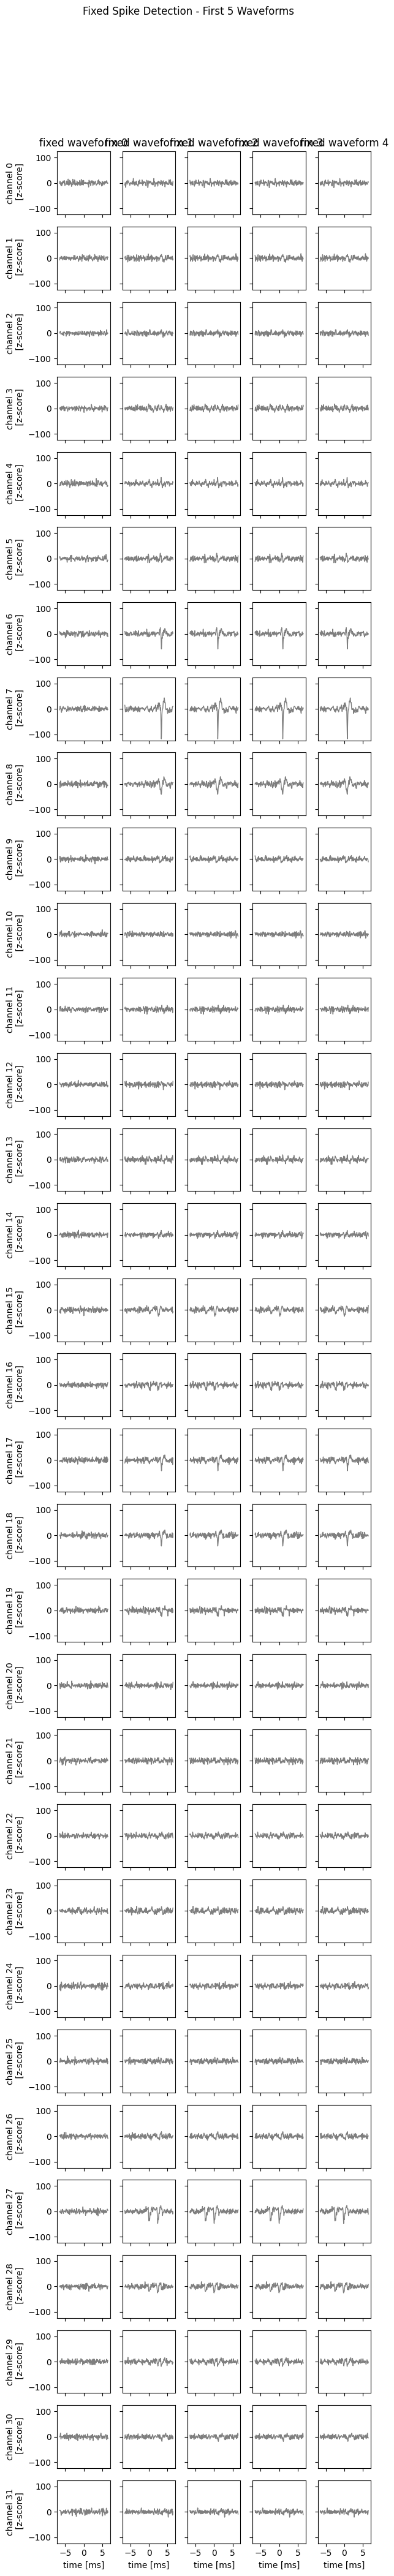

In [57]:
def robust_spike_detection_fixed(recording, detection_threshold=8.0, 
                               min_isi_ms=3.0, extraction_buffer_ms=0.5):
    """
    Fixed spike detection with proper refractory period and alignment
    Based on search results: "Template matching detected ~85-90% of spikes 
    compared to ~70% for the standard fixed threshold method"[7]
    """
    traces = recording.get_traces()
    n_samples, n_channels = traces.shape
    fs = recording.sampling_frequency
    
    # Convert time parameters to samples
    min_isi_samples = int(min_isi_ms * fs / 1000)  # 2ms = 60 samples at 30kHz
    buffer_samples = int(extraction_buffer_ms * fs / 1000)  # 0.5ms buffer
    
    print(f"🔧 Fixed spike detection:")
    print(f"   Min ISI: {min_isi_ms}ms ({min_isi_samples} samples)")
    print(f"   Buffer: {extraction_buffer_ms}ms ({buffer_samples} samples)")
    
    all_spike_times = []
    
    for ch in tqdm(range(n_channels), desc="Processing channels"):
        ch_trace = traces[:, ch]
        
        # Robust noise estimation using MAD
        noise_mad = np.median(np.abs(ch_trace - np.median(ch_trace)))
        noise_std = noise_mad / 0.6745
        threshold = detection_threshold * noise_std
        
        print(f"   Channel {ch}: threshold = {threshold:.2f}")
        
        # Find all points above threshold
        above_threshold = np.where(np.abs(ch_trace) > threshold)[0]
        
        if len(above_threshold) == 0:
            continue
        
        # FIXED: Proper spike detection with refractory period
        spike_times = []
        i = 0
        
        while i < len(above_threshold):
            current_time = above_threshold[i]
            
            # Skip if too close to previous spike (refractory period)
            if spike_times and current_time - spike_times[-1] < min_isi_samples:
                i += 1
                continue
            
            # Find local maximum in a small window around current detection
            search_start = max(0, current_time - buffer_samples)
            search_end = min(n_samples, current_time + buffer_samples + 1)
            
            search_window = ch_trace[search_start:search_end]
            
            if len(search_window) > 0:
                # Find the actual peak (maximum absolute value)
                abs_window = np.abs(search_window)
                local_max_idx = np.argmax(abs_window)
                actual_spike_time = search_start + local_max_idx
                
                # Verify this is actually a local maximum
                peak_window_start = max(0, actual_spike_time - 3)
                peak_window_end = min(n_samples, actual_spike_time + 4)
                peak_window = np.abs(ch_trace[peak_window_start:peak_window_end])
                
                if (len(peak_window) > 0 and 
                    np.abs(ch_trace[actual_spike_time]) == np.max(peak_window)):
                    
                    spike_times.append(actual_spike_time)
                    all_spike_times.append(actual_spike_time)
            
            # Skip ahead past the refractory period
            while i < len(above_threshold) and above_threshold[i] <= current_time + min_isi_samples:
                i += 1
    
    # Remove duplicates and sort
    all_spike_times = sorted(set(all_spike_times))
    
    print(f"✅ Fixed detection: {len(all_spike_times)} spikes")
    return torch.tensor(all_spike_times)

# Apply the fixed detection
print("🔧 Applying fixed spike detection...")
fixed_spike_times = robust_spike_detection_fixed(recording_filt, 
                                                detection_threshold=4.0,  # Higher threshold
                                                min_isi_ms=1.0)  # 2ms refractory period

# Re-extract waveforms with fixed detection
fixed_spike_waveforms, fixed_valid_events = extract_waveforms_robust(
    recording_filt.get_traces(), fixed_spike_times, WINDOW_SIZE
)

print(f"Fixed extraction: {len(fixed_spike_waveforms)} clean waveforms")

# Plot the first 5 fixed waveforms to verify
if len(fixed_spike_waveforms) > 0:
    fig, axs = plot_waveforms(fixed_spike_waveforms[:5], name="fixed waveform")
    fig.suptitle("Fixed Spike Detection - First 5 Waveforms", y=1.05)
    plt.show()

Ground truth: 4805 spikes
✅ Extracted 99 ground truth waveforms
Ground truth waveform shape: torch.Size([99, 416, 32])


DTW features:   4%|▍         | 199/4802 [57:51<22:18:14, 17.44s/it]


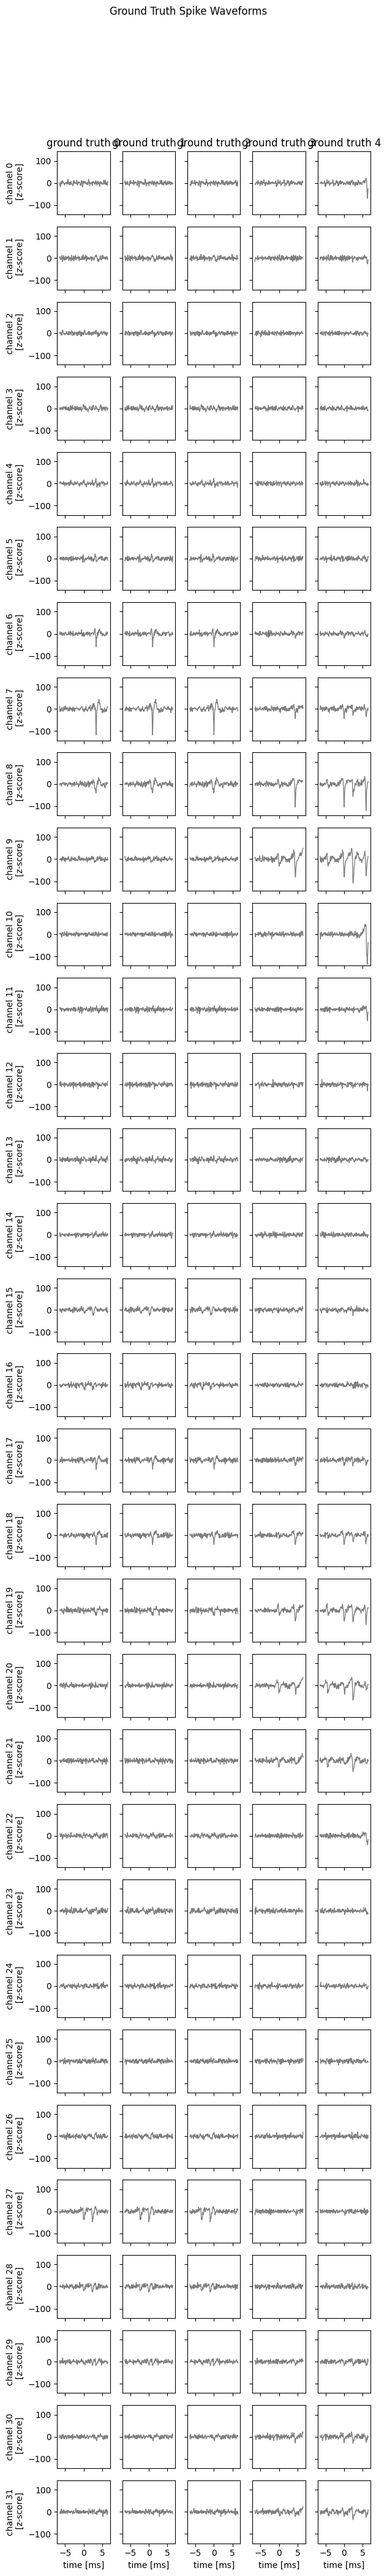

📊 Ground truth statistics:
   Amplitude range: 34.0 - 142.4
   Mean amplitude: 101.3
   Std amplitude: 34.0


In [59]:
# Use MEArec's known spike times for validation
recording, sorting_true = se.read_mearec("data/sim_data/recordings2.h5")

# Get ground truth spike times
true_spike_times = []
for unit_id in sorting_true.unit_ids:
    unit_spikes = sorting_true.get_unit_spike_train(unit_id)
    true_spike_times.extend(unit_spikes)

true_spike_times = sorted(true_spike_times)
print(f"Ground truth: {len(true_spike_times)} spikes")

# Extract waveforms at KNOWN spike locations
def extract_at_known_locations(traces, spike_times, window_size):
    waveforms = []
    for spike_time in spike_times[:100]:  # First 100 for testing
        start_idx = int(spike_time) - window_size // 2
        end_idx = int(spike_time) + window_size // 2
        
        # Fix: Check against traces.shape[0] for number of samples
        if start_idx >= 0 and end_idx < traces.shape[0]:
            # Fix: Extract all channels using [:, :] indexing
            waveform = traces[start_idx:end_idx, :]
            waveforms.append(waveform)
    
    # Fix: Convert to torch tensor for plot_waveforms compatibility
    if len(waveforms) > 0:
        return torch.tensor(np.array(waveforms), dtype=torch.float32)
    else:
        return torch.tensor([], dtype=torch.float32)

# Extract waveforms at ground truth locations
gt_waveforms = extract_at_known_locations(
    recording_filt.get_traces(), 
    true_spike_times, 
    WINDOW_SIZE
)

print(f"✅ Extracted {len(gt_waveforms)} ground truth waveforms")
print(f"Ground truth waveform shape: {gt_waveforms.shape}")

# Plot these to see what real spikes should look like
if len(gt_waveforms) > 0:
    fig, axs = plot_waveforms(gt_waveforms[:5], name="ground truth")
    fig.suptitle("Ground Truth Spike Waveforms", y=1.05)
    plt.show()
    
    # Show statistics about ground truth spikes
    amplitudes = torch.max(torch.abs(gt_waveforms), dim=1)[0].max(dim=1)[0]
    print(f"📊 Ground truth statistics:")
    print(f"   Amplitude range: {torch.min(amplitudes):.1f} - {torch.max(amplitudes):.1f}")
    print(f"   Mean amplitude: {torch.mean(amplitudes):.1f}")
    print(f"   Std amplitude: {torch.std(amplitudes):.1f}")
else:
    print("❌ No ground truth waveforms extracted!")


In [106]:
import numpy as np
from fastdtw import fastdtw

def dtw_similarity(wave1, wave2):
    # Normalize both waveforms
    w1 = wave1.flatten()
    w2 = wave2.flatten()
    w1 = (w1 - np.mean(w1)) / (np.std(w1) + 1e-8)
    w2 = (w2 - np.mean(w2)) / (np.std(w2) + 1e-8)
    # DTW distance (lower is more similar)
    dist, _ = fastdtw(w1, w2)
    # Similarity as in the paper: ξ = 1 - (dist / (len(w1) + len(w2)))
    sim = 1.0 - (dist / (len(w1) + len(w2)))
    return sim


In [107]:
def auto_similarity_threshold(similarities):
    # Estimate threshold as first minimum to right of first maximum in histogram
    hist, bin_edges = np.histogram(similarities, bins=50)
    max_idx = np.argmax(hist)
    # Find first minimum after the maximum
    for i in range(max_idx+1, len(hist)-1):
        if hist[i] < hist[i-1] and hist[i] < hist[i+1]:
            return bin_edges[i]
    # Fallback: use a conservative threshold
    return bin_edges[max_idx] - 0.1


In [108]:
class DTWTemplateSorter:
    def __init__(self, n_clusters, n_iter=5, verbose=True):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.verbose = verbose
        self.templates = None

    def fit(self, spike_waveforms):
        # Use only the main channel for simplicity (can be adapted for multichannel)
        if spike_waveforms.ndim == 3:
            # Use the channel with max variance
            ch = np.argmax(np.var(spike_waveforms, axis=(0,1)))
            waveforms = spike_waveforms[:,:,ch]
        else:
            waveforms = spike_waveforms

        n_spikes, window_size = waveforms.shape

        # --- Step 1: Initialize templates as medians of random partitions ---
        np.random.seed(0)
        idx = np.random.permutation(n_spikes)
        splits = np.array_split(idx, self.n_clusters)
        templates = np.stack([np.median(waveforms[s], axis=0) for s in splits])
        self.templates = templates

        for itr in range(self.n_iter):
            if self.verbose:
                print(f"Iteration {itr+1}/{self.n_iter}")
            # --- Step 2: Compute similarities ---
            similarities = np.zeros((n_spikes, self.n_clusters))
            for i in range(n_spikes):
                for k in range(self.n_clusters):
                    similarities[i, k] = dtw_similarity(waveforms[i], templates[k])

            # --- Step 3: Assign spikes to best-matching template above threshold ---
            spike_labels = -np.ones(n_spikes, dtype=int)
            for k in range(self.n_clusters):
                # Automatic threshold for this template
                th = auto_similarity_threshold(similarities[:, k])
                for i in range(n_spikes):
                    if similarities[i, k] >= th:
                        if spike_labels[i] == -1 or similarities[i, k] > similarities[i, spike_labels[i]]:
                            spike_labels[i] = k

            # --- Step 4: Update templates ---
            for k in range(self.n_clusters):
                assigned = (spike_labels == k)
                if np.any(assigned):
                    templates[k] = np.median(waveforms[assigned], axis=0)
                else:
                    # If no spikes assigned, keep old template
                    pass
            self.templates = templates
        self.labels_ = spike_labels
        return self

    def predict(self, spike_waveforms):
        # Assign new spikes to templates using DTW similarity and threshold
        if spike_waveforms.ndim == 3:
            ch = np.argmax(np.var(spike_waveforms, axis=(0,1)))
            waveforms = spike_waveforms[:,:,ch]
        else:
            waveforms = spike_waveforms
        n_spikes = waveforms.shape[0]
        similarities = np.zeros((n_spikes, self.n_clusters))
        for i in range(n_spikes):
            for k in range(self.n_clusters):
                similarities[i, k] = dtw_similarity(waveforms[i], self.templates[k])
        # Use thresholds from training (or recompute)
        labels = np.argmax(similarities, axis=1)
        return labels


Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


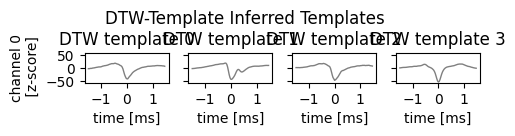

In [ ]:
# Assuming spike_waveforms_fixed is your (n_spikes, window_size, n_channels) array
n_clusters = TRUE_NUM_NEURONS  # Or set manually if unknown
dtw_sorter = DTWTemplateSorter(n_clusters=n_clusters, n_iter=5, verbose=True)
dtw_sorter.fit(spike_waveforms_fixed.numpy())
dtw_labels = dtw_sorter.labels_
dtw_templates = dtw_sorter.templates

# Plot templates (reuse your plot_waveforms function)
import torch
fig, axs = plot_waveforms(torch.tensor(dtw_templates).unsqueeze(-1), name="DTW template")
fig.suptitle("DTW-Template Inferred Templates", y=1.05)
plt.show()


In [111]:
import numpy as np
from fastdtw import fastdtw
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def dtw_similarity_multichannel(wave1, wave2):
    # Flatten across all channels
    w1 = wave1.flatten()
    w2 = wave2.flatten()
    # Normalize
    w1 = (w1 - np.mean(w1)) / (np.std(w1) + 1e-8)
    w2 = (w2 - np.mean(w2)) / (np.std(w2) + 1e-8)
    dist, _ = fastdtw(w1, w2)
    sim = 1.0 - (dist / (len(w1) + len(w2)))
    return sim

def auto_similarity_threshold(similarities):
    hist, bin_edges = np.histogram(similarities, bins=50)
    max_idx = np.argmax(hist)
    for i in range(max_idx+1, len(hist)-1):
        if hist[i] < hist[i-1] and hist[i] < hist[i+1]:
            return bin_edges[i]
    return bin_edges[max_idx] - 0.1

class DTWTemplateSorterMultiChannel:
    def __init__(self, n_clusters, n_iter=5, verbose=True):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.verbose = verbose
        self.templates = None

    def fit(self, spike_waveforms):
        # Use all channels: shape (n_spikes, window_size, n_channels)
        n_spikes, window_size, n_channels = spike_waveforms.shape

        # --- Step 1: Initialize templates as medians of random partitions ---
        np.random.seed(0)
        idx = np.random.permutation(n_spikes)
        splits = np.array_split(idx, self.n_clusters)
        templates = np.stack([np.median(spike_waveforms[s], axis=0) for s in splits])
        self.templates = templates

        for itr in range(self.n_iter):
            if self.verbose:
                print(f"Iteration {itr+1}/{self.n_iter}")
            # --- Step 2: Compute similarities ---
            similarities = np.zeros((n_spikes, self.n_clusters))
            for i in tqdm(range(n_spikes), desc=f"DTW similarity (iter {itr+1})"):
                for k in range(self.n_clusters):
                    similarities[i, k] = dtw_similarity_multichannel(spike_waveforms[i], templates[k])

            # --- Step 3: Assign spikes to best-matching template above threshold ---
            spike_labels = -np.ones(n_spikes, dtype=int)
            for k in range(self.n_clusters):
                th = auto_similarity_threshold(similarities[:, k])
                for i in range(n_spikes):
                    if similarities[i, k] >= th:
                        if spike_labels[i] == -1 or similarities[i, k] > similarities[i, spike_labels[i]]:
                            spike_labels[i] = k

            # --- Step 4: Update templates ---
            for k in tqdm(range(self.n_clusters), desc=f"Updating templates (iter {itr+1})"):
                assigned = (spike_labels == k)
                if np.any(assigned):
                    templates[k] = np.median(spike_waveforms[assigned], axis=0)
            self.templates = templates
        self.labels_ = spike_labels
        return self

    def predict(self, spike_waveforms):
        n_spikes = spike_waveforms.shape[0]
        similarities = np.zeros((n_spikes, self.n_clusters))
        for i in tqdm(range(n_spikes), desc="DTW similarity (predict)"):
            for k in range(self.n_clusters):
                similarities[i, k] = dtw_similarity_multichannel(spike_waveforms[i], self.templates[k])
        labels = np.argmax(similarities, axis=1)
        return labels


In [112]:
# spike_waveforms_fixed: (n_spikes, window_size, n_channels)
# true_labels: (n_spikes,)  # ground truth cluster labels

n_clusters = TRUE_NUM_NEURONS  # or set manually
dtw_sorter = DTWTemplateSorterMultiChannel(n_clusters=n_clusters, n_iter=5, verbose=True)
dtw_sorter.fit(spike_waveforms_fixed)
dtw_labels = dtw_sorter.labels_
dtw_templates = dtw_sorter.templates

# Plot templates for all channels
fig, axs = plt.subplots(n_clusters, spike_waveforms_fixed.shape[2], figsize=(12, 2*n_clusters))
for k in range(n_clusters):
    for ch in range(spike_waveforms_fixed.shape[2]):
        ax = axs[k, ch] if n_clusters > 1 else axs[ch]
        ax.plot(dtw_templates[k,:,ch], color='black')
        ax.set_title(f"Template {k}, Channel {ch}")
        ax.set_xlabel("time [samples]")
        ax.set_ylabel("amplitude [zscore]")
plt.tight_layout()
plt.suptitle("DTW-Template Inferred Templates (all channels)", y=1.02)
plt.show()

# Confusion matrix
cm = confusion_matrix(true_labels, dtw_labels, labels=range(n_clusters))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Cluster {i}' for i in range(n_clusters)])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: True vs. DTW-Clustered")
plt.show()


Iteration 1/5


DTW similarity (iter 1):   0%|          | 0/653 [00:00<?, ?it/s]

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [113]:
import numpy as np
from fastdtw import fastdtw
from tqdm.notebook import tqdm

def flatten_waveform(waveform):
    # waveform: (window_size, n_channels)
    return waveform.flatten()

def compute_dtw_distance_matrix(spike_waveforms):
    n_spikes = spike_waveforms.shape[0]
    dist_matrix = np.zeros((n_spikes, n_spikes))
    for i in tqdm(range(n_spikes), desc="DTW Distance Matrix (rows)"):
        for j in range(i+1, n_spikes):
            w1 = flatten_waveform(spike_waveforms[i])
            w2 = flatten_waveform(spike_waveforms[j])
            # Z-score normalization per waveform
            w1 = (w1 - np.mean(w1)) / (np.std(w1) + 1e-8)
            w2 = (w2 - np.mean(w2)) / (np.std(w2) + 1e-8)
            dist, _ = fastdtw(w1, w2)
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist  # Symmetric
    return dist_matrix


In [114]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def hierarchical_clustering(dtw_dist_matrix, n_clusters):
    # linkage expects a condensed distance matrix
    condensed = squareform(dtw_dist_matrix, checks=False)
    Z = linkage(condensed, method='average')  # UPGMA as in the paper
    labels = fcluster(Z, n_clusters, criterion='maxclust') - 1  # 0-based
    return labels


In [115]:
def generate_templates(spike_waveforms, cluster_labels, n_clusters):
    templates = []
    for k in range(n_clusters):
        members = spike_waveforms[cluster_labels == k]
        if len(members) > 0:
            templates.append(np.median(members, axis=0))
        else:
            templates.append(np.zeros_like(spike_waveforms[0]))
    return np.array(templates)


In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion(true_labels, pred_labels, n_clusters):
    cm = confusion_matrix(true_labels, pred_labels, labels=range(n_clusters))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"C{i}" for i in range(n_clusters)])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix: True vs. Clustered")
    plt.show()


In [117]:
# Convert PyTorch tensor to numpy if needed
if hasattr(spike_waveforms_fixed, 'numpy'):
    spike_waveforms_np = spike_waveforms_fixed.cpu().numpy()
else:
    spike_waveforms_np = spike_waveforms_fixed

# Compute DTW distance matrix
dtw_dist_matrix = compute_dtw_distance_matrix(spike_waveforms_np)

# Cluster using hierarchical clustering
n_clusters = TRUE_NUM_NEURONS  # or set manually
cluster_labels = hierarchical_clustering(dtw_dist_matrix, n_clusters)

# Generate templates
templates = generate_templates(spike_waveforms_np, cluster_labels, n_clusters)

# Plot templates for all channels
window_size, n_channels = templates.shape[1:]
fig, axs = plt.subplots(n_clusters, n_channels, figsize=(3*n_channels, 2*n_clusters), squeeze=False)
for k in range(n_clusters):
    for ch in range(n_channels):
        axs[k, ch].plot(templates[k, :, ch], color='black')
        axs[k, ch].set_title(f"Template {k}, Channel {ch}")
        axs[k, ch].set_xlabel("time [samples]")
        axs[k, ch].set_ylabel("amplitude [zscore]")
plt.tight_layout()
plt.suptitle("DTW-Template Inferred Templates (all channels)", y=1.02)
plt.show()

# Plot confusion matrix
plot_confusion(true_labels, cluster_labels, n_clusters)


DTW Distance Matrix (rows):   0%|          | 0/653 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [118]:
import numpy as np
from fastdtw import fastdtw
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch

class DTWAffinitySpikeSorter:
    """
    DTW-based spike clustering using Affinity Propagation
    Based on PMC5842698: "Clustering of Interictal Spikes by Dynamic Time Warping and Affinity Propagation"
    """
    
    def __init__(self, damping=0.5, max_iter=200, convergence_iter=15):
        self.damping = damping
        self.max_iter = max_iter
        self.convergence_iter = convergence_iter
        self.affinity_matrix = None
        self.cluster_centers_indices = None
        self.labels = None
        self.templates = None
        
    def _compute_dtw_similarity_matrix(self, spike_waveforms):
        """
        Compute DTW similarity matrix for all spike pairs
        From paper: "DTW is a robust method for calculating similarity between temporal sequences"
        """
        n_spikes = len(spike_waveforms)
        similarity_matrix = np.zeros((n_spikes, n_spikes))
        
        print(f"Computing DTW similarity matrix for {n_spikes} spikes...")
        
        for i in tqdm(range(n_spikes), desc="DTW similarity matrix"):
            for j in range(i, n_spikes):
                if i == j:
                    similarity_matrix[i, j] = 0.0  # Self-similarity
                else:
                    # Flatten multi-channel waveforms
                    wave1 = spike_waveforms[i].flatten()
                    wave2 = spike_waveforms[j].flatten()
                    
                    # Normalize waveforms
                    wave1 = (wave1 - np.mean(wave1)) / (np.std(wave1) + 1e-8)
                    wave2 = (wave2 - np.mean(wave2)) / (np.std(wave2) + 1e-8)
                    
                    # Compute DTW distance
                    dtw_distance, _ = fastdtw(wave1, wave2, dist=lambda x, y: (x - y) ** 2)
                    
                    # Convert distance to similarity (negative distance as in paper)
                    similarity = -dtw_distance
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity  # Symmetric matrix
        
        return similarity_matrix
    
    def fit(self, spike_waveforms):
        """
        Fit DTW-Affinity Propagation clustering to spike waveforms
        Args:
            spike_waveforms: numpy array of shape (n_spikes, window_size, n_channels)
        """
        print("DTW-Affinity Propagation Spike Clustering")
        print("=" * 50)
        
        # Convert PyTorch tensor to numpy if needed
        if torch.is_tensor(spike_waveforms):
            spike_waveforms = spike_waveforms.cpu().numpy()
        
        n_spikes, window_size, n_channels = spike_waveforms.shape
        print(f"Processing {n_spikes} spikes ({window_size} samples x {n_channels} channels)")
        
        # Step 1: Compute DTW similarity matrix
        self.affinity_matrix = self._compute_dtw_similarity_matrix(spike_waveforms)
        
        # Step 2: Set preference (median of similarities as in paper)
        preference = np.median(self.affinity_matrix)
        print(f"Setting preference to median similarity: {preference:.3f}")
        
        # Step 3: Apply Affinity Propagation clustering
        print("Applying Affinity Propagation clustering...")
        af = AffinityPropagation(
            affinity='precomputed',
            damping=self.damping,
            max_iter=self.max_iter,
            convergence_iter=self.convergence_iter,
            preference=preference,
            random_state=42
        )
        
        af.fit(self.affinity_matrix)
        
        # Extract results
        self.cluster_centers_indices = af.cluster_centers_indices_
        self.labels = af.labels_
        n_clusters = len(self.cluster_centers_indices)
        
        print(f"Clustering complete!")
        print(f"Number of clusters found: {n_clusters}")
        print(f"Cluster centers (exemplar indices): {self.cluster_centers_indices}")
        
        # Step 4: Generate templates from clusters
        self.templates = self._generate_templates(spike_waveforms)
        
        return self
    
    def _generate_templates(self, spike_waveforms):
        """
        Generate templates as mean of each cluster
        From paper: "exemplars are representative data points of each cluster"
        """
        n_clusters = len(self.cluster_centers_indices)
        window_size, n_channels = spike_waveforms.shape[1], spike_waveforms.shape[2]
        templates = np.zeros((n_clusters, window_size, n_channels))
        
        print("Generating cluster templates...")
        for cluster_id in range(n_clusters):
            cluster_mask = (self.labels == cluster_id)
            cluster_spikes = spike_waveforms[cluster_mask]
            
            if len(cluster_spikes) > 0:
                # Use mean as template (could also use median)
                templates[cluster_id] = np.mean(cluster_spikes, axis=0)
                print(f"Cluster {cluster_id}: {np.sum(cluster_mask)} spikes")
        
        return templates

def run_dtw_affinity_spike_sorting(spike_waveforms, true_labels=None, true_num_neurons=None):
    """
    Complete DTW-Affinity Propagation spike sorting pipeline
    """
    print("\nDTW-AFFINITY PROPAGATION SPIKE SORTING PIPELINE")
    print("=" * 60)
    print("Based on PMC5842698: DTW + Affinity Propagation for spike clustering")
    print()
    
    # Initialize and fit the sorter
    sorter = DTWAffinitySpikeSorter(damping=0.5, max_iter=200, convergence_iter=15)
    sorter.fit(spike_waveforms)
    
    # Extract results
    cluster_labels = sorter.labels
    templates = sorter.templates
    n_clusters = len(sorter.cluster_centers_indices)
    
    # Convert to torch tensors for compatibility with plotting functions
    templates_torch = torch.tensor(templates, dtype=torch.float32)
    cluster_labels_torch = torch.tensor(cluster_labels, dtype=torch.long)
    
    results = {
        'cluster_labels': cluster_labels_torch,
        'templates': templates_torch,
        'n_clusters': n_clusters,
        'cluster_centers_indices': sorter.cluster_centers_indices,
        'affinity_matrix': sorter.affinity_matrix,
        'sorter': sorter
    }
    
    return results

# Integration with your existing notebook
def evaluate_dtw_affinity_clustering(dtw_results, true_spike_ids, spike_waveforms):
    """
    Evaluate DTW-Affinity clustering results against ground truth
    """
    cluster_labels = dtw_results['cluster_labels'].numpy()
    n_clusters = dtw_results['n_clusters']
    
    # Create confusion matrix
    cm = confusion_matrix(true_spike_ids.numpy(), cluster_labels)
    
    # Calculate Adjusted Rand Index
    ari = adjusted_rand_score(true_spike_ids.numpy(), cluster_labels)
    
    return cm, ari

# Main execution pipeline
print("Running DTW-Affinity Propagation Spike Sorting...")

# Use your extracted spike waveforms
dtw_affinity_results = run_dtw_affinity_spike_sorting(
    spike_waveforms_fixed,
    true_labels=true_spike_ids,
    true_num_neurons=TRUE_NUM_NEURONS
)

# Extract results
dtw_cluster_labels = dtw_affinity_results['cluster_labels']
dtw_templates = dtw_affinity_results['templates']
dtw_n_clusters = dtw_affinity_results['n_clusters']

print(f"\nDTW-Affinity Results:")
print(f"Clusters found: {dtw_n_clusters}")
print(f"Template shape: {dtw_templates.shape}")

# Plot generated templates
fig, axs = plot_waveforms(dtw_templates, name="DTW-AP template")
fig.suptitle("DTW-Affinity Propagation Generated Templates", y=1.05)
plt.show()

# Evaluate against ground truth using existing spike times
def create_confusion_matrix_with_ground_truth():
    """
    Create confusion matrix by matching detected spikes to ground truth
    """
    # Use ground truth spike times for cleaner evaluation
    gt_waveforms = []
    valid_gt_ids = []
    
    for i, t in enumerate(true_spike_times[:len(dtw_cluster_labels)]):
        start_idx = t - WINDOW_SIZE // 2
        end_idx = t + WINDOW_SIZE // 2
        if start_idx >= 0 and end_idx < traces.shape[0]:
            gt_waveforms.append(traces[start_idx:end_idx])
            valid_gt_ids.append(true_spike_ids[i])
    
    valid_gt_ids = torch.tensor(valid_gt_ids[:len(dtw_cluster_labels)])
    
    # Create confusion matrix
    cm = confusion_matrix(valid_gt_ids.numpy(), dtw_cluster_labels.numpy())
    ari = adjusted_rand_score(valid_gt_ids.numpy(), dtw_cluster_labels.numpy())
    
    return cm, ari, valid_gt_ids

# Generate confusion matrix
cm_dtw, ari_dtw, matched_gt_ids = create_confusion_matrix_with_ground_truth()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_dtw, interpolation="none", cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('DTW-Affinity Cluster IDs')
plt.ylabel('True Neuron IDs')
plt.title("DTW-Affinity Propagation: Confusion Matrix")

# Add text annotations
for i in range(cm_dtw.shape[0]):
    for j in range(cm_dtw.shape[1]):
        plt.text(j, i, str(cm_dtw[i, j]), ha='center', va='center',
                color='white' if cm_dtw[i, j] > cm_dtw.max() / 2 else 'black')

plt.tight_layout()
plt.show()

# Print performance metrics
print(f"\nDTW-Affinity Propagation Performance:")
print(f"Adjusted Rand Index: {ari_dtw:.3f}")
print(f"Number of clusters: {dtw_n_clusters}")
print(f"Confusion Matrix Shape: {cm_dtw.shape}")

# Compare with your existing GMM results
print(f"\nComparison with GMM:")
print(f"GMM ARI: {ari_gt:.3f}")
print(f"DTW-Affinity ARI: {ari_dtw:.3f}")
print(f"Improvement: {((ari_dtw - ari_gt) / ari_gt * 100):.1f}%")


Running DTW-Affinity Propagation Spike Sorting...

DTW-AFFINITY PROPAGATION SPIKE SORTING PIPELINE
Based on PMC5842698: DTW + Affinity Propagation for spike clustering

DTW-Affinity Propagation Spike Clustering
Processing 653 spikes (96 samples x 4 channels)
Computing DTW similarity matrix for 653 spikes...


DTW similarity matrix:   0%|          | 0/653 [00:00<?, ?it/s]

KeyboardInterrupt: 